# Изучение конверсии в покупку пользователей мобильного приложения по продаже продуктов питания и анализ результатов A/A/B-теста по изменению шрифтов

## Содержание


- [**Шаг 1. Общая информация о данных**](#part_1)
    - [1.1. Введение в проект](#101)
    - [1.2. Загрузка библиотек и глобальные настройки](#102)
    - [1.3. Описание данных](#103)
    - [1.4. Выводы из общей информации о данных](#104)


- [**Шаг 2. Проверка данных перед анализом**](#part_2)


- [**Шаг 3. Изучение воронки событий**](#part_3)


- [**Шаг 4. Изучение результатов эксперимента**](#part_4)
    - [2.1. Контрольные группы А/А-эксперимента](#401)
    - [2.2. Контрольные группы А/А-эксперимента по каждому событию](#402)
    - [2.3. Экспериментальная и две контрольные группы A/B-эксперимента по каждому событию](#403)


- [**Шаг 5. Общие выводы**](#part_5) 

<a id='part_1'></a>
## Шаг 1. Общая информация о данных

<a id='101'></a>
### Введение в проект

Компания продает продукты питания. Нужно изучить поведение пользователей мобильного приложения — сколько доходят до покупки, а сколько остаются на предыдущих этапах. Также нужно обработать результаты A/A/B-эксперимента — дизайнеры предлагают изменить шрифты в приложении. Пользователи разбиты на 2 контрольные группы со старыми шрифтами и одну экспериментальную группу — с новыми. Две контрольные группы нужны для лучшего контроля скрытых факторов, аномалий в данных и ошибок в разделении на группы.

<a id='102'></a>
### Загрузка библиотек и глобальные настройки

In [1]:
import pandas as pd
from pandas.api.types import CategoricalDtype
import warnings

import math as mth
import numpy as np
import scipy.stats as st
from statsmodels.stats.proportion import proportions_ztest

import matplotlib.pyplot as plt
import seaborn as sns

import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go

In [2]:
pd.set_option('display.max_columns', None)

# тема и цветовая схема для интерактивных диаграмм
# создание шаблона, который применяет ко всем диаграммам выбранную цветовую схему в формате HEX
coolwarm_palette = sns.color_palette('coolwarm', n_colors=10).as_hex()
pio.templates['coolwarm'] = go.layout.Template(
    layout=go.Layout(
        yaxis={'showgrid': True}, 
        colorway=coolwarm_palette, 
        colorscale={'sequential': coolwarm_palette, 'diverging': coolwarm_palette}))

# применение шаблона вместе со встроенной темой
pio.templates.default = 'simple_white+coolwarm'

<a id='103'></a>
### Описание данных

Каждая запись в логе — это действие пользователя, или событие.
- `EventName` — название события;
- `DeviceIDHash` — уникальный идентификатор пользователя;
- `EventTimestamp` — время события;
- `ExpId` — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

In [3]:
# чтение файла с данными
original_logs_exp = pd.read_csv('./datasets/logs_exp.csv', sep='\t')

# создание рабочей копии файла с данными
logs_exp = original_logs_exp.copy()

# вывод информации и первых 5 строк
logs_exp.info()
logs_exp.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
EventName         244126 non-null object
DeviceIDHash      244126 non-null int64
EventTimestamp    244126 non-null int64
ExpId             244126 non-null int64
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


Для удобства переименуем столбцы, переведем `EventTimestamp` из unix-формата в читаемый вид, а также выведем даты событий, без времени, в отдельный столбец.

In [4]:
# сменим названия столбцов
logs_exp.columns = ['event_name', 'device_id_hash', 'event_timestamp', 'exp_id']

# переведем event_timestamp из unix в datetime и выведем в отдельный столбец даты событий
logs_exp['event_timestamp'] = pd.to_datetime(logs_exp['event_timestamp'], unit='s')
logs_exp['event_date'] = logs_exp['event_timestamp'].astype('datetime64[D]')

logs_exp.head()

,event_name,device_id_hash,event_timestamp,exp_id,event_date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25


In [5]:
print('Количество полностью дублированных строк:', logs_exp.duplicated().sum())
print('Процент дубликатов от общих данных: {:.2%}'.format(logs_exp.duplicated().sum() / len(logs_exp)))

logs_exp = logs_exp.drop_duplicates()

Количество полностью дублированных строк: 413
Процент дубликатов от общих данных: 0.17%


17 сотых процента дубликатов мы можем безопасно удалить.

In [6]:
# количество уникальных значений в каждом столбце
logs_exp.nunique()

event_name              5
device_id_hash       7551
event_timestamp    176654
exp_id                  3
event_date             14
dtype: int64

<a id='104'></a>
### Выводы из общей информации о данных

Нам доступны данные о поведении 7 551 пользователя мобильного приложения для заказа продуктов за 14 дней, которые разбиты на 3 группы по 5 событий в каждом. Вот что можно сказать из первичного изучения данных:

1. Данные соответствуют полученному описанию.
1. В таблице нашлись 0,17% полностью дублированных строк, что некорректно — эти записи мы удалили.
1. Перевели `event_timestamp` в формат читаемых дат, а остальные типы данных соответствуют признакам.
1. Пропусков в данных не обнаружено.
1. Аномалий или нелогичных данных на первый взгляд нет, но в дальнейшем стоит проверить последовательность появления событий. 

<a id='part_2'></a>
## Шаг 2. Проверка данных перед анализом

Нам нужно убедиться, что в данных нет аномалий, которые помещают анализу сплит-теста. Сначала посмотрим общую информацию — сколько пользователей и сколько событий в выборке:

In [7]:
print('Всего событий зафиксировано в логе:', logs_exp.shape[0])

Всего событий зафиксировано в логе: 243713


In [8]:
print('Всего типов событий в логе:', logs_exp['event_name'].nunique())

Всего типов событий в логе: 5


In [9]:
print('Всего пользователей в логе:', logs_exp['device_id_hash'].nunique())

Всего пользователей в логе: 7551


In [10]:
print('Среднее количество событий на пользователя: {:.1f}'.format(
    logs_exp['event_timestamp'].count() / logs_exp['device_id_hash'].nunique()))

Среднее количество событий на пользователя: 32.3


Проверим, нет ли пересекающихся событий, которые случайно попали в выборку. У нас должны быть полные данные за весь период. Определим временные границы эксперимента и построим гистограмму временных отметок:

In [11]:
print('Минимальная дата:', logs_exp['event_timestamp'].min())
print('Максимальная дата:', logs_exp['event_timestamp'].max())

Минимальная дата: 2019-07-25 04:43:36
Максимальная дата: 2019-08-07 21:15:17


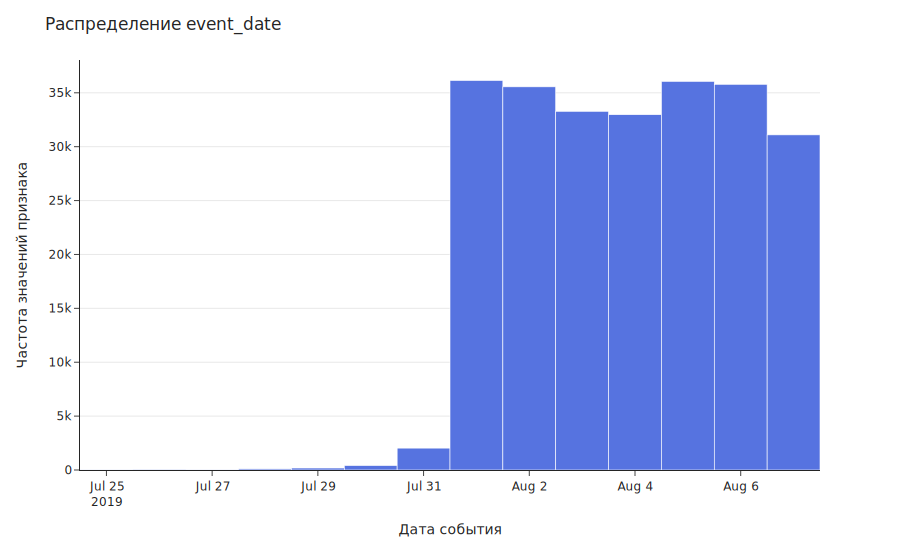

In [12]:
px.histogram(
    logs_exp['event_date']
).update_layout(
    showlegend=False, 
    xaxis_type='date', 
    title='Распределение event_date', 
    xaxis_title='Дата события', 
    yaxis_title='Частота значений признака'
).show(renderer='svg', width=900, height=550)

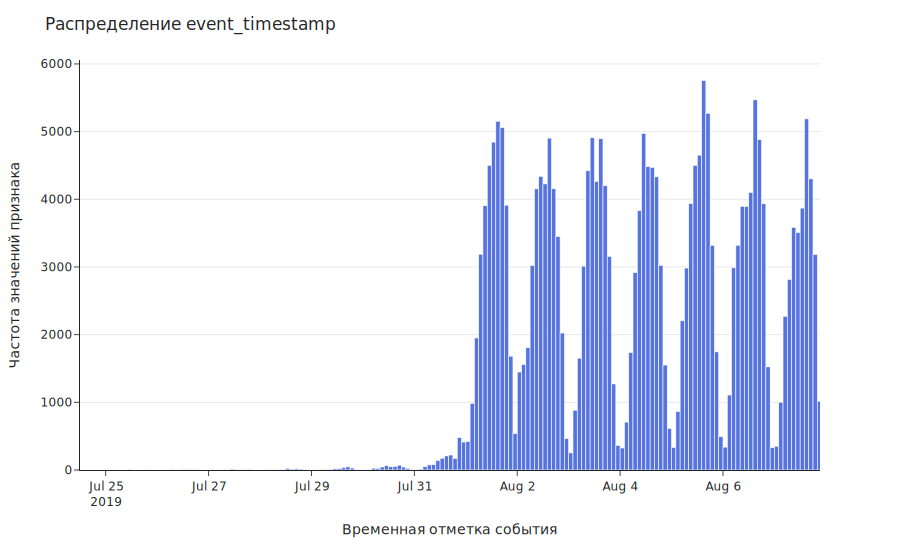

In [13]:
px.histogram(
    logs_exp['event_timestamp'], 
    nbins=200
).update_layout(
    showlegend=False, 
    xaxis_type='date', 
    title='Распределение event_timestamp', 
    xaxis_title='Временная отметка события', 
    yaxis_title='Частота значений признака', 
    xaxis_range=['2019-07-24 12:00:00', logs_exp['event_timestamp'].max()]
).show(renderer='svg', width=900, height=550)

Самая ранняя дата — 25 июля, но вплоть до 1 августа наблюдений заметно меньше — похоже, это и есть пересекающиеся события. Их нужно отбросить, чтобы не было перекоса в выборках. Возьмем данные, поступившие с 12 часов ночи 1 августа:

In [14]:
logs_exp_filtered = logs_exp[logs_exp['event_timestamp'] >= '2019-08-01 00:00:00']

print('Будут отфильтрованы {:.2%} данных'.format(
    abs(len(logs_exp_filtered) / len(logs_exp) - 1)))
print('Количество пользователей уменьшилось на {:.2%}'.format(
    abs(logs_exp_filtered['device_id_hash'].nunique() / logs_exp['device_id_hash'].nunique() - 1)))

Будут отфильтрованы 1.16% данных
Количество пользователей уменьшилось на 0.23%


In [15]:
# скрипт для форматирования timedelta — разделение строки на дни, часы, минуты и секунды
def strfdelta(tdelta, fmt):
    d = {'days': tdelta.days}
    d['hours'], rem = divmod(tdelta.seconds, 3600)
    d['minutes'], d['seconds'] = divmod(rem, 60)
    return fmt.format(**d)


print('Минимальная дата в отфильтрованных данных:', logs_exp_filtered['event_timestamp'].min())
print('Максимальная дата в отфильтрованных данных:', logs_exp_filtered['event_timestamp'].max())
print(strfdelta(logs_exp_filtered['event_timestamp'].max() - logs_exp_filtered['event_timestamp'].min(), 
                'Длительность эксперимента: {days} дней, {hours} часов, {minutes} минут и {seconds} секунд'))

Минимальная дата в отфильтрованных данных: 2019-08-01 00:07:28
Максимальная дата в отфильтрованных данных: 2019-08-07 21:15:17
Длительность эксперимента: 6 дней, 21 часов, 7 минут и 49 секунд


Теперь у нас есть более точные данные о времени эксперимента.

In [16]:
logs_exp_filtered['exp_id'].value_counts()

248    84563
246    79302
247    77022
Name: exp_id, dtype: int64

Также у нас есть данные из всех трех экспериментальных групп.

<a id='part_3'></a>
## Шаг 3. Изучение воронки событий

После того, как мы отбросили некорректные данные, мы можем изучить этапы, которые проходили пользователи. Посмотрим, какие события есть в логах, как часто они встречаются и сколько пользователей совершили каждое из событий:

In [17]:
logs_exp_filtered['event_name'].value_counts()

MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: event_name, dtype: int64

In [18]:
users_in_events = logs_exp_filtered.groupby('event_name')['device_id_hash'].nunique().sort_values(ascending=False)

pd.concat([
    users_in_events.rename('n_users'), 
    users_in_events.rename('initial_percent').apply(
        lambda x: x / logs_exp_filtered['device_id_hash'].nunique()).map('{:.2%}'.format)], axis=1)

,n_users,initial_percent
event_name,,
MainScreenAppear,7419,98.47%
OffersScreenAppear,4593,60.96%
CartScreenAppear,3734,49.56%
PaymentScreenSuccessful,3539,46.97%
Tutorial,840,11.15%


Здесь события описывают путь от входа в приложение до оплаты заказа; на каждом этапе часть пользователей теряется. Ожидаемо самое популярное событие — это появление стартового экрана. А вот самое редкое — это онбординг, обучение новых пользователей, и видно, что по количеству наблюдений и пользователей оно заметно отличается — это потому, что обучение демонстрируется только новым пользователям. Конечно же, онбординг не может идти после всех остальных этапов.

Таким образом, мы можем выстроить события в следующую цепочку:

**(Tutorial) → MainScreenAppear → OffersScreenAppear → CartScreenAppear → PaymentScreenSuccessful**

Обучение — необязательный этап. Поскольку мы анализируем всех пользователей за время эксперимента, а не только новичков, то этап `Tutorial` мы исключим из анализа.

Сформируем последовательность согласно приведенной нами цепочке и проверим, всегда ли пользователи строго ей следуют:

In [19]:
events_cat = CategoricalDtype(categories=['Tutorial', 
                                          'MainScreenAppear', 
                                          'OffersScreenAppear', 
                                          'CartScreenAppear', 
                                          'PaymentScreenSuccessful'], ordered=True)

with warnings.catch_warnings():
    warnings.simplefilter('ignore') # выключение предупреждения об использовании .loc
    logs_exp_filtered['event_category'] = logs_exp_filtered['event_name'].astype(events_cat)
    logs_exp_filtered['event_code'] = logs_exp_filtered['event_category'].cat.codes

logs_exp_filtered.head()

,event_name,device_id_hash,event_timestamp,exp_id,event_date,event_category,event_code
2828,Tutorial,3737462046622621720,2019-08-01 00:07:28,246,2019-08-01,Tutorial,0
2829,MainScreenAppear,3737462046622621720,2019-08-01 00:08:00,246,2019-08-01,MainScreenAppear,1
2830,MainScreenAppear,3737462046622621720,2019-08-01 00:08:55,246,2019-08-01,MainScreenAppear,1
2831,OffersScreenAppear,3737462046622621720,2019-08-01 00:08:58,246,2019-08-01,OffersScreenAppear,2
2832,MainScreenAppear,1433840883824088890,2019-08-01 00:08:59,247,2019-08-01,MainScreenAppear,1


In [20]:
# сбор самой ранней временной отметки, когда события демонстрировались пользователям
first_event_by_users = \
logs_exp_filtered.groupby(['device_id_hash', 'event_code', 'event_name'])['event_timestamp'].min()
first_event_by_users = first_event_by_users.reset_index()

# подсчет временной дельты между каждым последующим событием цепочки отдельно для каждого пользователя
event_timedelta = \
first_event_by_users.groupby('device_id_hash')['event_timestamp'].diff()
first_event_by_users['event_timedelta_sec'] = event_timedelta.apply(lambda x: x.total_seconds()).fillna(0)

print('Минимум {} раз пользователи были на последующих этапах воронки раньше предыдущих этапов'.format(
    len(first_event_by_users.query('event_timedelta_sec < 0'))))

Минимум 2777 раз пользователи были на последующих этапах воронки раньше предыдущих этапов


В чуть более чем полутора процентах случаев пользователи были на более поздних этапах цепочки до более ранних. Посмотрим на примере частных случаев, как это может быть:

In [21]:
first_event_by_users.query('device_id_hash == 6909561520679493')

,device_id_hash,event_code,event_name,event_timestamp,event_timedelta_sec
1,6909561520679493,1,MainScreenAppear,2019-08-06 18:52:54,0.0
2,6909561520679493,2,OffersScreenAppear,2019-08-06 18:53:04,10.0
3,6909561520679493,3,CartScreenAppear,2019-08-06 18:52:58,-6.0
4,6909561520679493,4,PaymentScreenSuccessful,2019-08-06 18:52:58,0.0


In [22]:
first_event_by_users.query('device_id_hash == 18658818197810381')

,device_id_hash,event_code,event_name,event_timestamp,event_timedelta_sec
30,18658818197810381,1,MainScreenAppear,2019-08-02 03:05:37,0.0
31,18658818197810381,2,OffersScreenAppear,2019-08-01 08:00:42,-68695.0
32,18658818197810381,3,CartScreenAppear,2019-08-01 15:25:32,26690.0
33,18658818197810381,4,PaymentScreenSuccessful,2019-08-03 13:47:35,166923.0


Первый пользователь перешел в корзину до просмотра товаров, а второй переходил в корзину и товары за день до главного экрана. Это не обязательно может быть ошибкой, но стоит этот момент в дальнейшем проверить. В любом случае, таких событий совсем небольшое количество, они не исказят данные эксперимента.

По указанной нами цепочке построим воронку событий и посчитаем, какая доля пользователей переходит на каждый следующий этап и где теряется больше всего пользователей:

event_name
MainScreenAppear           98.47%
OffersScreenAppear         61.91%
CartScreenAppear           81.30%
PaymentScreenSuccessful    94.78%
Name: device_id_hash, dtype: object

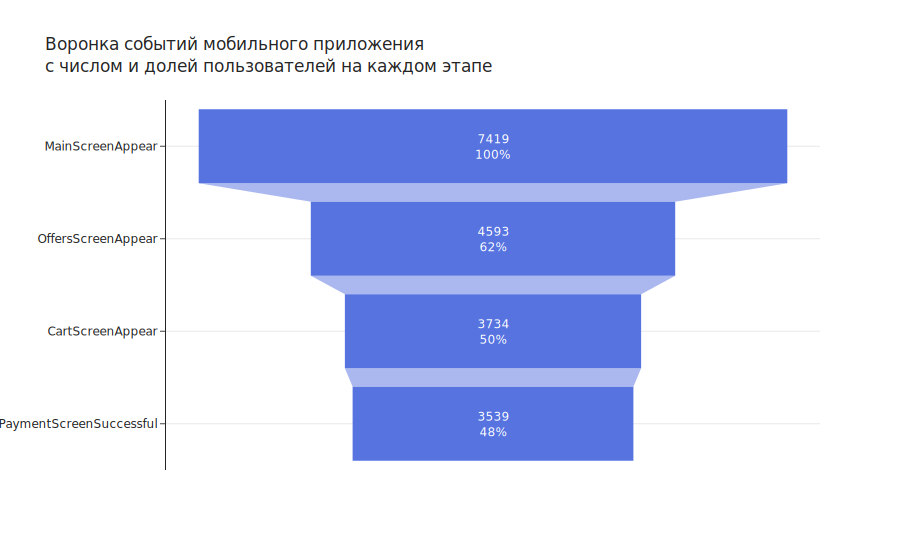

In [23]:
# подсчет процента различий между последующим и предыдущим событием
# первое событие — процент от общего числа пользователей
display(users_in_events[:-1].pct_change().apply(lambda x: 1 + x)
        .fillna(users_in_events[0] / logs_exp_filtered['device_id_hash'].nunique()).map('{:.2%}'.format))

go.Figure(go.Funnel(
    x=users_in_events[:-1].values, 
    y=users_in_events[:-1].index, 
    textinfo='value+percent initial'
)).update_layout(
    title='Воронка событий мобильного приложения'+
    '<br><i>с числом и долей пользователей на каждом этапе').show(
    renderer='svg', 
    width=900, 
    height=550)

На первом этапе воронки MainScreenAppear у нас меньше 100%, т.к. мы считали проценты от общего количества пользователей — это как раз исключенные из анализа новички, которые сначала видели онбординг. Похоже, что 1,5% процента не прошли дальше него.

In [24]:
print('При переходе к событию {} теряется больше всего пользователей: {:.2%}'.format(
    users_in_events.index[users_in_events.pct_change().values == users_in_events[:-1].pct_change().min()][0], 
    abs(users_in_events[:-1].pct_change().min())))

При переходе к событию OffersScreenAppear теряется больше всего пользователей: 38.09%


In [25]:
successful_payments = users_in_events[:-1].apply(lambda x: x / logs_exp_filtered['device_id_hash'].nunique()).iloc[[-1]]
print('До события {} от первого этапа доходят {:.2%} пользователей'
      .format(successful_payments.index[0], successful_payments.values[0]))

До события PaymentScreenSuccessful от первого этапа доходят 46.97% пользователей


Итак, больше всего пользователей увидели главный экран приложения, но только 62% из них перешли непосредственно к покупкам, а завершили этот процесс и сделали оплату чуть менее 47%.

<a id='part_4'></a>
## Шаг 4. Изучение результатов эксперимента

In [26]:
# количество пользователей в каждой группе
logs_exp_filtered.groupby('exp_id')['device_id_hash'].nunique()

exp_id
246    2484
247    2513
248    2537
Name: device_id_hash, dtype: int64

Перейдем к оценке результатов сплит-теста. В эксперименте участвовали три группы, в каждой около 2,5 тысяч пользователей. Напомним, что в сплит-тесте участвовали две контрольные группы, между которыми был проведен А/А-тест — т.е. им демонстрировалася одна и та же исходная версия приложения. Это нужно, чтобы проверить корректность деления на группы и исключить влияние аномалий и скрытых факторов на результаты.

In [27]:
# количество уникальных id устройств, которым приписаны две группы
(logs_exp_filtered.groupby('device_id_hash')['exp_id'].nunique() > 1).sum()

0

In [28]:
# подсчет различий между количеством пользователей в каждой группе
pd.Series(
    index=['247 / 246', '248 / 246', '248 / 247'], 
    data=[
        logs_exp_filtered.query('exp_id == 247')['device_id_hash'].nunique() / 
        logs_exp_filtered.query('exp_id == 246')['device_id_hash'].nunique() - 1, 
        logs_exp_filtered.query('exp_id == 248')['device_id_hash'].nunique() / 
        logs_exp_filtered.query('exp_id == 246')['device_id_hash'].nunique() - 1, 
        logs_exp_filtered.query('exp_id == 248')['device_id_hash'].nunique() / 
        logs_exp_filtered.query('exp_id == 247')['device_id_hash'].nunique() - 1
    ]).map('{:.2%}'.format).rename('compare_samples')

247 / 246    1.17%
248 / 246    2.13%
248 / 247    0.96%
Name: compare_samples, dtype: object

Ни один пользователь не попал сразу в несколько групп — это было бы грубой ошибкой эксперимента. Разница в количестве пользователей между группами — не более 2,13%, это допустимый уровень.

Посмотрим, как выглядит воронка для каждой из групп:

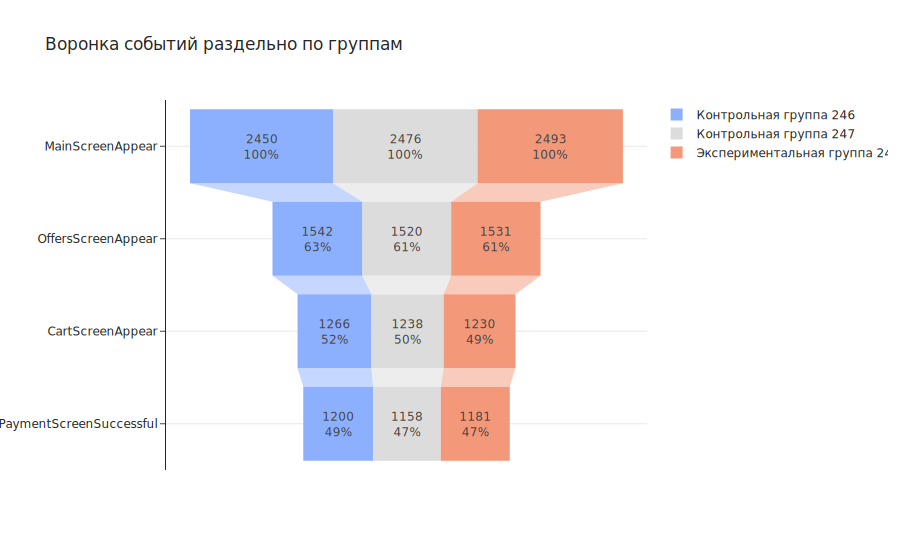

In [29]:
fig = go.Figure()

fig.add_trace(go.Funnel(
    x=logs_exp_filtered.query('exp_id == 246').groupby('event_category')['device_id_hash'].nunique()[1:].values, 
    y=logs_exp_filtered.query('exp_id == 246').groupby('event_category')['device_id_hash'].nunique()[1:].index, 
    name='Контрольная группа 246', 
    marker_color=sns.color_palette('coolwarm', n_colors=3).as_hex()[0], 
    textinfo='value+percent initial'
))

fig.add_trace(go.Funnel(
    x=logs_exp_filtered.query('exp_id == 247').groupby('event_category')['device_id_hash'].nunique()[1:].values, 
    y=logs_exp_filtered.query('exp_id == 247').groupby('event_category')['device_id_hash'].nunique()[1:].index, 
    name='Контрольная группа 247', 
    marker_color=sns.color_palette('coolwarm', n_colors=3).as_hex()[1], 
    textinfo='value+percent initial'
))

fig.add_trace(go.Funnel(
    x=logs_exp_filtered.query('exp_id == 248').groupby('event_category')['device_id_hash'].nunique()[1:].values, 
    y=logs_exp_filtered.query('exp_id == 248').groupby('event_category')['device_id_hash'].nunique()[1:].index, 
    name='Экспериментальная группа 248', 
    marker_color=sns.color_palette('coolwarm', n_colors=3).as_hex()[2], 
    textinfo='value+percent initial'
))

fig.update_layout(title='Воронка событий раздельно по группам')
fig.show(renderer='svg', width=900, height=550)

Доли пользователей на каждом этапе близки между группами и соответствуют общей тенденции. Аномалий и несоответствий мы не наблюдаем, поэтому перейдем к статистической оценке различий.

<a id='401'></a>
### Контрольные группы А/А-эксперимента

Нам важно, чтобы между контрольными группами не было значимых различий — тогда мы можем признать, что распределение по группам было корректным. Проверим гипотезу о равенстве долей с помощью Z-теста пропорций для двух независимых выборок. Он рассчитывается по следуюшей формуле:

$$Z \approx \frac{(P_1 − P_2) − (\pi_1 − \pi_2)}{P * (1 − P) * (1/n_1 + 1/n_2)} \sim \mathcal{N}{(0, 1)}$$

В формуле встречаются следующие значения:
- $Z$ — стандартная величина для стандартного нормального распределения $\mathcal{N}$;
- $n_1$ и $n_2$ — размеры выборок;
- $P_1$ и $P_2$ — пропорции в выборках, а $P$ — пропорция, скомбинированная из двух наблюдаемых;
- $\pi_1$ и $\pi_2$ — пропорции в генеральной совокупности, мы проверяем нулевую гипотезу о равенстве этих пропорций.

Нулевая гипотеза в этом тесте утверждает равенство долей, т.е. что различий в пропорциях нет; альтернативная — что такие различия есть. Решение мы можем принять по критическому уровню значимости — заданной вероятности ошибочно отвергнуть нулевую гипотезу; в данном случае принимаем его за 1%. Для расчетов используем готовую функцию `statsmodels.stats.proportion.proportions_ztest`, определим альтернативную гипотезу для нее как двустороннюю — у нас нет информации о том, что доля любой из групп будет выше или ниже:

In [30]:
z_alpha = .01 # контрольный уровень значимости
z_results = proportions_ztest(
    count=[logs_exp_filtered.query('exp_id == 246')['device_id_hash'].nunique(), # размер выборки первой группы
           logs_exp_filtered.query('exp_id == 247')['device_id_hash'].nunique()], # размер выборки второй группы
    nobs=[logs_exp_filtered['device_id_hash'].nunique()] * 2, # общее число пользователей (нужно указать дважды)
    alternative='two-sided') 


print('p-значение (Z-тест для пропорций): {:.10f}'.format(z_results[1]))
if (z_results[1] < z_alpha):
    print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
else:
    print('Не получилось отвергнуть нулевую гипотезу: нет оснований считать доли разными')

p-значение (Z-тест для пропорций): 0.6158048203
Не получилось отвергнуть нулевую гипотезу: нет оснований считать доли разными


Тест показывает: вероятность ошибочно сделать вывод о различиях между пропорциями двух контрольных групп — свыше 61%. Т.е. мы можем достоверно утверждать, что пропорции действительно взяты из одной генеральной совокупности, что нам и нужно.

<a id='402'></a>
### Контрольные группы А/А-эксперимента по каждому событию

Проведем ту же процедуру для каждого отдельного события — нет ли на каком-либо из этапов различия между контрольными группами? Нулевая гипотеза также утверждает равенство сравниваемых долей, а альтернативная — различия в пропорциях.

Для удобства введем функцию, которая позволит автоматизировать вывод Z-теста. По умолчанию установим уровень значимости за 1%. Также включим в вывод количество пользователей в каждой группе, долю каждого события от общего количества пользователей в группе и конверсию на каждом этапе воронки:

In [31]:
def ztest_by_events(groups: list=None, 
                    events: list=None, 
                    raw_data: 'pd.DataFrame'=None, 
                    agg_data: 'pd.DataFrame'=None, 
                    initial: list=None, 
                    text: bool=False, 
                    alternative: str='two-sided', 
                    alpha: float=.01):
    
    '''
    Функция нужна для автоматизации вызова statsmodels.stats.proportion.proportions_ztest 
    при проверке результатов эксперимента по каждому этапу воронки.
    
    Аргументы:
    - events: название событий, передается для среза по event_categories 
    - groups: номера групп, между которыми сравниваются доли; ожидается не более двух групп
    - raw_data: исходный датафрейм с «сырыми» данными
    - agg_data: датафрейм с посчитанными долями для каждой группы
    - initial: лист с объемом выборок каждой группы
    - text: выводить ли результат в текстовом виде (по умолчанию — агрегированная таблица)
    - alternative: аргумент alternative функции statsmodels.stats.proportion.proportions_ztest
    - alpha: критический уровень значимости, с которым сравнивается p-value теста 
    '''
    
    # по умолчанию используем отфильтрованный датафрейм
    if raw_data is None:
        raw_data = logs_exp_filtered
    
    # по умолчанию подсчитываем число пользователей в каждой группе по каждому событию
    if agg_data is None:
        agg_data = raw_data.groupby(['exp_id', 'event_category'])['device_id_hash'].nunique().reset_index()
    
    # по умолчанию список событий извлекается из соответствующего столбца агрегированных данных
    if events is None:
        events = agg_data['event_category'].unique()
    
    # по умолчанию группы извлекаются из соответствующего столбца агрегированных данных
    if groups is None:
        groups = agg_data['exp_id'].unique().tolist()
    
    # подсчет числа уникальных пользователей в каждой группе; передается в nobs функции proportions_ztest
    if initial is None:
        initial = [raw_data.loc[raw_data['exp_id'] == groups[0], 'device_id_hash'].nunique(), 
                   raw_data.loc[raw_data['exp_id'] == groups[1], 'device_id_hash'].nunique()]
    
    # если получены агрегированные данные в виде Series, у них сбрасывается индекс для перехода в DataFrame
    if isinstance(agg_data, pd.Series):
        agg_data = agg_data.reset_index()
    
    # цикл по каждому событию из списка событий
    for event in events:
        
        # цикл по каждой группе из списка групп
        for group in groups:
            
            # подсчет доли пользователей каждого события каждой группы от общего числа пользователей в группе
            agg_data.loc[agg_data['exp_id'] == group, 'initial_percent'] = \
            agg_data.loc[agg_data['exp_id'] == group, 'device_id_hash'] / initial[groups.index(group)]
            
            # вывод результатов подсчет в текстовом виде
            if text == True:
                n_users = agg_data.loc[(agg_data['exp_id'] == group) & (agg_data['event_category'] == event), 
                                       'device_id_hash'].values[0]
                percent = agg_data.loc[(agg_data['exp_id'] == group) & (agg_data['event_category'] == event), 
                                       'total_percent'].values[0]
                print('В группе {} событие {} увидели {} пользователей ({:.2%})'
                      .format(group, event, n_users, percent))
        
        # проведение Z-теста для проверки нулевой гипотезы о равенстве долей
        trials = initial # исходный размер групп
        successes = [
            agg_data.loc[(agg_data['event_category'] == event) & (agg_data['exp_id'] == groups[0]), 
                         'device_id_hash'].values[0], 
            agg_data.loc[(agg_data['event_category'] == event) & (agg_data['exp_id'] == groups[1]), 
                         'device_id_hash'].values[0]] # пропорция успешных событий в группах
        
        z_alpha = alpha # контрольный уровень значимости, по умолчанию 0.01
        z_results = proportions_ztest(count=successes, nobs=trials, alternative=alternative)
        
        # сравнение с тестовым уровнем значимости; если он меньше контрольного — нулевая гипотеза отвергается
        agg_data.loc[agg_data['event_category'] == event, 'p_value'] = z_results[1]
        if (z_results[1] < z_alpha):
            agg_data.loc[agg_data['event_category'] == event, 'h0_rejected'] = True
        else:
            agg_data.loc[agg_data['event_category'] == event, 'h0_rejected'] = False
        
        # вывод результатов Z-теста в текстовом виде
        if text == True:
            print('p-значение (Z-тест для пропорций): {:.10f}'.format(z_results[1]))
            if (z_results[1] < z_alpha):
                print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
            else:
                print('Не получилось отвергнуть нулевую гипотезу: нет оснований считать доли разными')
            print()
    
    # вывод результатов проверки в табличном виде
    if text == False:
        output = agg_data.groupby(['event_category', 'exp_id']).last()
        output = output.query('event_category in @events and exp_id in @groups')
        return output

In [32]:
ztest_by_events(groups=[246, 247], events=logs_exp_filtered['event_category'].cat.categories[1:])\
.style.format(dict(total_percent='{:.2%}', initial_percent='{:.2%}', p_value='{:.6f}'))

Для всех событий вероятность ошибочно допустить различия между пропорциями контрольных групп выше критического уровня значимости в 1%. Значит, мы можем достоверно утверждать о правильности разделения на группы для каждого события.

<a id='403'></a>
### Экспериментальная и две контрольные группы A/B-эксперимента по каждому событию

Повторим процедуру проверки гипотезы о равенстве долей, но теперь уже между экспериментальной и контрольными группами. Сделаем это сравнение как попарно, так и с объединенной контрольной группой:

In [33]:
ztest_by_events(groups=[246, 248], events=logs_exp_filtered['event_category'].cat.categories[1:])\
.style.format(dict(total_percent='{:.2%}', initial_percent='{:.2%}', p_value='{:.6f}'))

In [34]:
ztest_by_events(groups=[247, 248], events=logs_exp_filtered['event_category'].cat.categories[1:])\
.style.format(dict(total_percent='{:.2%}', initial_percent='{:.2%}', p_value='{:.6f}'))

In [35]:
# подготовка объединенной контрольной группы

# подсчет количества уникальных пользователей в обеих контрольных группах
combined_groups = logs_exp_filtered.query('exp_id in [246, 247]')
combined_groups = combined_groups.groupby(['exp_id', 'event_category'])['device_id_hash'].nunique().reset_index()

# сумма пользователей двух контрольных групп по каждому событию
combined_groups = \
combined_groups.groupby('event_category').apply(lambda x: x['device_id_hash'].sum())\
.rename('device_id_hash').reset_index()

# название объединенной группы и перевод в строковый формат
combined_groups['exp_id'] = '246+247'
combined_groups['exp_id'] = combined_groups['exp_id'].astype(str)

# присоединение данных о количестве пользователей по каждому событию в экспериментальной группе
combined_groups = \
combined_groups.append(logs_exp_filtered.query('exp_id == 248')
                       .groupby(['exp_id', 'event_category'])['device_id_hash'].nunique()
                       .reset_index(), sort=False).reset_index(drop=True)

# исключение события Tutorial и упорядочивание столбцов в итоговой таблице
combined_groups = \
combined_groups[combined_groups['event_category'] != 'Tutorial'][['exp_id', 'event_category', 'device_id_hash']]

# подсчет исходного числа пользователей в экспериментальной и объединенной контрольной группах
initial_control = (logs_exp_filtered.query('exp_id == 246')['device_id_hash'].nunique() + 
                   logs_exp_filtered.query('exp_id == 247')['device_id_hash'].nunique())
initial_experiment = logs_exp_filtered.query('exp_id == 248')['device_id_hash'].nunique()

# запуск функции с Z-тестом
ztest_by_events(agg_data=combined_groups, initial=[initial_control, initial_experiment])\
.style.format(dict(total_percent='{:.2%}', initial_percent='{:.2%}', p_value='{:.6f}'))

Для оценки результатов A/B-теста мы сделали в сумме 12 проверок. Увы, ни одна не показала значимых различий между долями, поэтому у нас нет оснований считать, что шрифт действительно влияет на конверсию — ни улучшает ее, ни ухудшает. Мы проверяли по более строгому критерию точности, допуская вероятность ложного результата в 1%, но даже если мы увеличим ее до 5%, ситуация не изменится.

<a id='part_5'></a>
## Шаг 5. Общие выводы

Напомним, что целью нашего исследования был анализ конверсии пользователей мобильного приложения в платящих пользователей, а также изучение результатов A/A/B-эксперимента с целью выяснить, приводит ли смена шрифтов в приложении к изменениям в конверсии.

В эксперименте принял участие 7 551 пользователь, которых мы разделили на три группы примерно по 2,5 тысячи в каждой — две из них были контрольные, и им демонстрировалась текущая версия приложения, а одна была экспериментальной, они видели версию с новыми шрифтами. Временные границы эксперимента: с 2019-08-01 00:07:28 до 2019-08-07 21:15:17, общая длительность эксперимента — 6 дней, 21 часов, 7 минут и 49 секунд.

Мы изучили следующие события в приложении: онбординг → появление главной страницы → появление страницы с предложениями (товарами) → переход в корзину → появление страницы с успешной оплатой заказа. Мы выстроили их в воронку событий и изучили конверсию на каждом ее этапе. Такие выводы мы можем сделать из этого:
- Из воронки **исключили онбординг**, т.к. он демонстрировался только новым пользователям, а в выборках были не только они. Тем не менее, около 1,5% пользователей не прошли дальше обучения — им не демонстрировался главный экран.
- **Больше всего пользователей теряется** при переходе от главного экрана к странице с товарами, это первый и второй этап воронки (не считая онбординг) — к просмотру товаров переходят 62% пользователей.
- **Конверсия в оплату** — чуть менее 47%, столько дошли до последнего этапа воронки. Напомним, что это конверсия из пользователей мобильного приложения.
- Также в около 1,5% случаев более поздние события воронки демонстрировались до более ранних. Стоит проверить, не является ли это ошибкой. Тем не менее, таких событий мало и они существенно не влияют на результаты анализа.

Мы проверили статистическую значимость A/A/B-теста: сравнили доли пользователей от общего количества на каждом этапе воронки попарно между каждой из групп, а также между экспериментальной и объединенной контрольной группами. Вот что можно сказать в итоге:
- Между **контрольными группами** не были обнаружены значимые различия ни между долями групп в целом, ни между долями групп по каждому событию воронки. Это значит, что мы можем полагаться на результаты исследования этих групп, они были разделены правильно.
- Между **экспериментальной и контрольными группами** также не были обнаружены значимые различия между долями ни по одному событию воронки, как в случае с каждой контрольной группой отдельно, так и с объединенной контрольной группой. Т.е. мы не можем достоверно утверждать, что изменение шрифта улучшает или ухудшает конверсию. 

Соответственно, особого смысла менять шрифт в приложении на данный момент нет.